In [1]:
data_dir= '/kaggle/input/celebrity-face-recognition-dataset'

In [ ]:
 pip install wurlitzer


In [ ]:
pip install keras==2.15.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import img_to_array
import glob
import os
from keras.models import Sequential
from keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,BatchNormalization,Dropout
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.applications import MobileNet,VGG16,VGG19,InceptionV3,EfficientNetB0,DenseNet201,MobileNetV3Large,EfficientNetV2L,ResNet152
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras import optimizers,layers

2024-03-10 06:18:14.367340: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 06:18:14.367409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 06:18:14.368943: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Prepration And Preprocessing:

In [3]:
# data=image_dataset_from_directory(
#     data_dir,
#     labels='inferred',
#     label_mode='int',
#     class_names=None,
#     color_mode='rgb',
#     batch_size=32,
#     image_size=(256, 256),
#     shuffle=True,
#     seed=None,
#     validation_split=None,
#     subset=None,
#     interpolation='bilinear',
#     follow_links=False,
#     crop_to_aspect_ratio=False,
#     data_format=None,
# )

In [4]:
images_path=glob.glob(data_dir+'/**/*.jpg',recursive=True, root_dir=data_dir)

In [5]:
images_path[:5]

['/kaggle/input/celebrity-face-recognition-dataset/Angelina Jolie/049_4d6df392.jpg',
 '/kaggle/input/celebrity-face-recognition-dataset/Angelina Jolie/051_268fdfd7.jpg',
 '/kaggle/input/celebrity-face-recognition-dataset/Angelina Jolie/045_c560251e.jpg',
 '/kaggle/input/celebrity-face-recognition-dataset/Angelina Jolie/052_6db5f5bf.jpg',
 '/kaggle/input/celebrity-face-recognition-dataset/Angelina Jolie/006_9135205d.jpg']

In [6]:
labels= []
for img in images_path :
    lab= os.path.dirname(img)
    labels.append(lab)

In [7]:
image_labels=[]
for label in labels:
    lab=label.split('/')[-1]
    image_labels.append(lab)

In [8]:
image_labels[:10]

['Angelina Jolie',
 'Angelina Jolie',
 'Angelina Jolie',
 'Angelina Jolie',
 'Angelina Jolie',
 'Angelina Jolie',
 'Angelina Jolie',
 'Angelina Jolie',
 'Angelina Jolie',
 'Angelina Jolie']

In [9]:
preprocessed_images = []


for file in images_path:
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128,128))
    img = img / 255
    
    preprocessed_images.append(img)
    


In [10]:
X= np.array(preprocessed_images)

In [11]:
X.shape

(1800, 128, 128, 3)

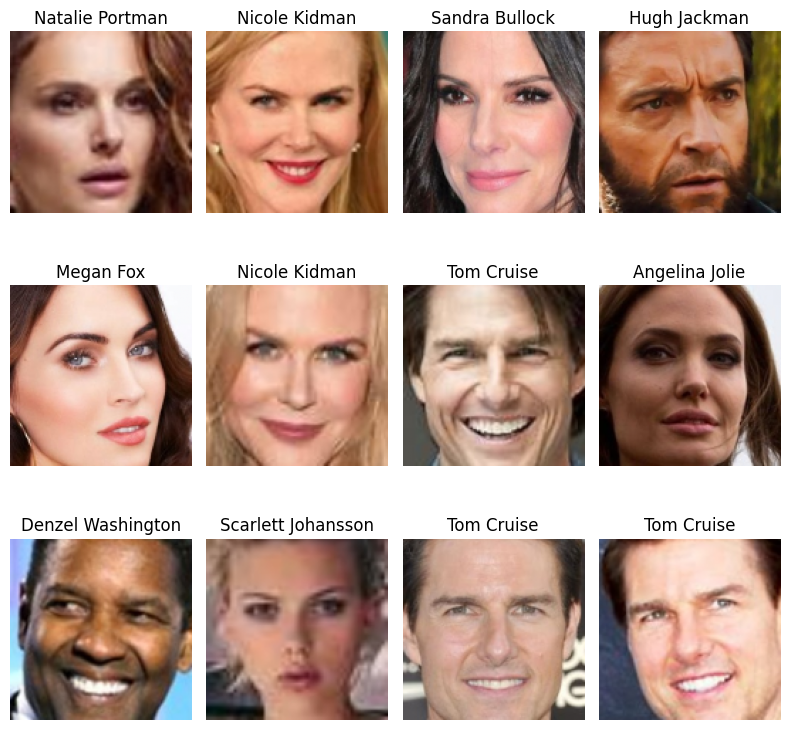

In [12]:
plt.figure(figsize=(8, 8))
random_indices = np.random.choice(len(X), size=12, replace=False)  # Choose 12 random indices without replacement
for i, index in enumerate(random_indices):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X[index], cmap='gray')
    plt.title(image_labels[index])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [13]:
y= np.array(image_labels)

In [14]:
encoder= LabelEncoder()
y=encoder.fit_transform(y)

In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.005,random_state=42,shuffle=True)

# Model Training:

In [16]:
# # Load DenseNet201 with pre-trained weights (ImageNet)
# base_model = DenseNet201(weights='imagenet', include_top=False,input_shape=(224,224,3))

# # Freeze the base model layers
# for layer in base_model.layers:
#     layer.trainable = False

In [17]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.optimizers import Adam

# Define a ModelCheckpoint callback to save the best weights based on validation accuracy
checkpoint_acc = ModelCheckpoint(filepath='best_weights_acc.keras', 
                                 monitor='val_accuracy', 
                                 verbose=1, 
                                 save_best_only=True,
                                 mode='max')

# Define a ModelCheckpoint callback to save the best weights based on validation loss
checkpoint_loss = ModelCheckpoint(filepath='best_weights_loss.keras', 
                                  monitor='val_loss', 
                                  verbose=1, 
                                  save_best_only=True,
                                  mode='min')

In [18]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# Create a Sequential model
model = Sequential()

# Add DenseNet201 as the first layer
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
model.add(base_model)

# Flatten the output of the base model
model.add(layers.Flatten())

# Add fully connected layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(17, activation='softmax'))  # Assuming 17 classes for the output layer


# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dense (Dense)               (None, 128)               3932288   
                                                                 
 dense_1 (Dense)             (None, 17)                2193      
                                                                 
Total params: 22256465 (84.90 MB)
Trainable params: 22027409 (84.03 MB)
Non-trainable params: 229056 (894.75 KB)
_________________________________________________________________


In [19]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dense (Dense)               (None, 128)               3932288   
                                                                 
 dense_1 (Dense)             (None, 17)                2193      
                                                                 
Total params: 22256465 (84.90 MB)
Trainable params: 22027409 (84.03 MB)
Non-trainable params: 229056 (894.75 KB)
_________________________________________________________________


In [21]:
encoder.classes_

array(['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman',
       'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet',
       'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman',
       'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock',
       'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith'],
      dtype='<U18')

In [22]:
# Train the model with the ModelCheckpoint callbacks
history = model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=32, 
                    validation_data=(X_test, y_test),
                    callbacks=[checkpoint_acc, checkpoint_loss])

# Load the best weights onto the model for accuracy
model.load_weights('best_weights_acc.keras')

# Load the best weights onto the model for loss
model.load_weights('best_weights_loss.keras')

Epoch 1/20


I0000 00:00:1710051597.961931    1215 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 [==============================] - ETA: 0s - loss: 1.5636 - accuracy: 0.5343
Epoch 1: val_accuracy improved from -inf to 0.55556, saving model to best_weights_acc.keras

Epoch 1: val_loss improved from inf to 1.05584, saving model to best_weights_loss.keras
56/56 [==============================] - 162s 652ms/step - loss: 1.5636 - accuracy: 0.5343 - val_loss: 1.0558 - val_accuracy: 0.5556
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 0.1025 - accuracy: 0.9793
Epoch 2: val_accuracy improved from 0.55556 to 0.77778, saving model to best_weights_acc.keras

Epoch 2: val_loss improved from 1.05584 to 0.44854, saving model to best_weights_loss.keras
56/56 [==============================] - 20s 353ms/step - loss: 0.1025 - accuracy: 0.9793 - val_loss: 0.4485 - val_accuracy: 0.7778
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9983
Epoch 3: val_accuracy improved from 0.77778 to 1.00000, saving model to best_weights_acc.keras


In [23]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 61ms/step - loss: 0.0709 - accuracy: 1.0000


[0.0709477961063385, 1.0]

In [ ]:
model.save('HCFR.h5')

In [ ]:
from keras.models import load_model

# Load the model
model = load_model('HCFR.h5')


# Real Time Model(Only Work With Webcam/Camera):

In [ ]:
labels= encoder.classes_

In [ ]:

# Load the pre-trained Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Assuming you have a function to preprocess images for your model
def preprocess_image(img):
    img = cv2.resize(img, (48,48))  # Resize the image to match the input shape of the model
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = img / 255.0  # Normalize pixel values to range [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Assuming you have a function to predict labels using your model
def predict_label(img):
    pred = model.predict(img)
    y_pred = np.argmax(pred, axis=1)
    return y_pred

# Map predicted index to label
def map_to_label(predicted_index, label_mapping):
    return label_mapping[predicted_index]

# Open a connection to the first camera device
cap = cv2.VideoCapture(0)

# Loop to capture frames from the camera
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Process each detected face
    for (x, y, w, h) in faces:
        # Crop the detected face
        face = frame[y:y+h, x:x+w]

        # Preprocess the face for your model
        preprocessed_face = preprocess_image(face)

        # Predict the label for the face
        predicted_label_index = predict_label(preprocessed_face)

        # Map predicted index to label
        predicted_label = labels[predicted_label_index]

        # Draw rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 5)

        # Put text with predicted label on the frame
        cv2.putText(frame, str(predicted_label), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,1, (0, 255, 0),2)

    # Display the resulting frame
    cv2.imshow('Face Detection with Predicted Labels', frame)

    # Check if the user pressed 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()
